# analyze `allblocks-quorum.db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks.db` database (created by `blocksDB_create.py`) containing all the blocks.

In this specific case the "Quorum" client of the EEA.

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://gitlab.com/electronDLT/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


---

<a id='chainhammer1000'>1000 TPS shot at the Quorum-Raft node</a>
# my own experiment: 
## 3 times 1000 transactions submitted with `chainhammer` 

Three times, I have committed 1000 transactions, for details see

https://gitlab.com/electronDLT/chainhammer/blob/master/chainreader/quorum-log.md
    


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [all 3 consecutive experiments](#allExperiments)
* [experiment 1](#experiment 1)
* [experiment 3](#experiment 3)


<a id='database'>Database</a>

In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

DBFILE="allblocks-quorum.db"
print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.3
matplotlib version 2.2.2

Reading blocks table from allblocks-quorum.db


### TODO: refactoring
all the following functions could go into a separate `blocksDB_diagramming.py` for better recycling.

**For now, please simply scroll down.**

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

# any SQL query 

def DB_query(SQL, conn):
    cur = conn.cursor()
    cur.execute(SQL)
    result = cur.fetchall()
    return result

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?

def DB_tableSize(tablename, conn):
    """
    prints number of rows
    """
    count = DB_query("SELECT COUNT(*) FROM %s" % tablename, conn)
    print ("TABLE %s has %d rows" % (tablename, count[0][0]))
    return count
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?

def maxBlockNumber(conn):
    result = DB_query("SELECT MIN(blocknumber), MAX(blocknumber) FROM blocks", conn)
    print ("MIN(blocknumber), MAX(blocknumber) = %s " % (result) )
    return result
minblock, maxblock = maxBlockNumber(conn)[0]

DB table names:  ('blocks',)
TABLE blocks has 358 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 357)] 


In [ ]:
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

len(blocknumbers)= 358


In [ ]:
# do we have consecutive blocks, none missing?

def check_whether_complete(blocknumbers):
    start = min(blocknumbers)[0]
    last = max(blocknumbers)[0]
    old = start-1
    total=0
    for bn in blocknumbers:
        bn = bn[0]
        missing=bn-old-1
        if missing>0:
            print ("from ", old+1, "to", bn - 1, "there are ", missing, " missing")
            total+=missing
        old = bn
    print()
    print ("complete" if not total else "some %d blocks missing" % total, end=" ")
    print ("between blocks %d and %d." %(min(blocknumbers)[0], max(blocknumbers)[0]))
    
check_whether_complete(blocknumbers)


complete between blocks 0 and 357.


<a id='stats'>simple statistics</a>

In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 3787
txcount_max 24
txcount_av 8.38268156424581
txcount_sum 3001
blocks_nonempty_count 357
av tx per nonempty blocks =  8.406162464985995


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### `geth` based clients have a nanosecond timestamp

In [ ]:
# transform nanoseconds to seconds
df["timestamp"]=df["timestamp"]/1000000000

In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]

def add_blocktime(df):
    df['blocktime'] = df['timestamp'] - df['timestamp'].shift()
    df.loc[1, "blocktime"] = numpy.nan
    
add_blocktime(df)


In [ ]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [ ]:
# transactions per second
# with differently sized (rectangular) windows

def add_TPS(df, numBlocks):
    name = 'TPS_%dblks'%numBlocks if numBlocks>1 else 'TPS_%dblk'%numBlocks
    df[name]=df['txcount'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()
    
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [ ]:
# gasUsed and gasLimit per second

def add_GUPS(df, numBlocks):
    name = 'GUPS_%dblks'%numBlocks if numBlocks>1 else 'GUPS_%dblk'%numBlocks
    df[name]=df['gasUsed'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

def add_GLPS(df, numBlocks):
    name = 'GLPS_%dblks'%numBlocks if numBlocks>1 else 'GLPS_%dblk'%numBlocks
    df[name]=df['gasLimit'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
346,346,1.526986e+09,2562,321960,2680184879,15,0.032399,462.978122,171.397884,191.116390,167.851130,9.937362e+06,3.678884e+06,4.102122e+06,8.272446e+10,5.305698e+10,5.346141e+10
357,357,1.526986e+09,3651,493672,2651536730,23,0.051411,447.375828,243.221987,198.547311,178.135947,9.602475e+06,5.220517e+06,4.261619e+06,5.157537e+10,5.234129e+10,5.274857e+10
58,58,1.526986e+09,3649,493672,3551066768,23,0.053133,432.872017,169.413242,153.100684,156.375329,9.291165e+06,3.636286e+06,3.286153e+06,6.683293e+10,5.161594e+10,5.795049e+10
36,36,1.526986e+09,2953,386352,3628216379,18,0.043223,416.448168,162.717449,157.725909,174.204761,8.938643e+06,3.492567e+06,3.385429e+06,8.394245e+10,7.708062e+10,7.351072e+10
153,153,1.526986e+09,3106,407816,3236319927,19,0.048294,393.421123,238.332664,210.940045,190.833516,8.444391e+06,5.115572e+06,4.527617e+06,6.701245e+10,6.433958e+10,6.452880e+10
302,302,1.526986e+09,3107,407816,2797905786,19,0.048717,390.011237,159.140637,187.852201,161.151564,8.371201e+06,3.415795e+06,4.032060e+06,5.743235e+10,5.571199e+10,5.602354e+10
314,314,1.526986e+09,3651,493672,2765296592,23,0.059007,389.781579,203.318606,182.176472,168.984842,8.366272e+06,4.364031e+06,3.910236e+06,4.686355e+10,5.276119e+10,5.869276e+10
343,343,1.526986e+09,2291,279032,2688051586,13,0.035070,370.687805,205.998260,192.462169,163.025580,7.956443e+06,4.421547e+06,4.131008e+06,7.664830e+10,5.363955e+10,5.399589e+10
42,42,1.526986e+09,2969,386352,3607010925,18,0.049957,360.309600,140.828626,183.285440,159.009573,7.733685e+06,3.022746e+06,3.934039e+06,7.220226e+10,5.447862e+10,6.021875e+10
148,148,1.526986e+09,2970,386352,3252167028,18,0.051148,351.918706,213.075128,170.770412,171.963757,7.553583e+06,4.573445e+06,3.665416e+06,6.358325e+10,6.502814e+10,6.470473e+10


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
273,273,1.526986e+09,2427,300496,2878308337,14,0.049476,282.964639,221.688388,183.870415,204.671034,6.073553e+06,4.758320e+06,3.946595e+06,5.817568e+10,5.806467e+10,5.763819e+10
135,135,1.526986e+09,1066,85856,3293734905,4,0.025392,157.531065,154.659955,173.436222,203.811656,3.381247e+06,3.319621e+06,3.722635e+06,1.297164e+11,6.650960e+10,7.531194e+10
290,290,1.526986e+09,2699,343424,2830899902,16,0.058793,272.143134,207.001220,173.686294,198.992088,5.841280e+06,4.443074e+06,3.728003e+06,4.815062e+10,5.499119e+10,5.473896e+10
156,156,1.526986e+09,1882,214640,3226848691,10,0.055931,178.791434,127.701090,173.417857,197.948918,3.837579e+06,2.740976e+06,3.722241e+06,5.769329e+10,6.187125e+10,6.371457e+10
67,67,1.526986e+09,1473,150248,3519980686,7,0.050684,138.109415,156.188918,171.465609,195.907272,2.964380e+06,3.352439e+06,3.680338e+06,6.944892e+10,7.178081e+10,7.031822e+10
136,136,1.526986e+09,2154,257568,3290518494,12,0.067759,177.099395,163.469394,170.776614,195.258169,3.801261e+06,3.508707e+06,3.665549e+06,4.856240e+10,6.212596e+10,6.256036e+10
349,349,1.526986e+09,1883,214640,2672341448,10,0.049520,201.937574,183.284253,181.354152,194.543141,4.334388e+06,3.934013e+06,3.892586e+06,5.396461e+10,5.447522e+10,5.646378e+10
157,157,1.526986e+09,1338,128784,3223697787,6,0.041584,144.287867,169.873964,182.560537,193.766056,3.096995e+06,3.646175e+06,3.918479e+06,7.752341e+10,7.474879e+10,6.551907e+10
138,138,1.526986e+09,1746,193176,3284095280,9,0.029631,303.732095,151.784142,152.373986,193.442682,6.519306e+06,3.257895e+06,3.270555e+06,1.108317e+11,6.508187e+10,6.775539e+10
134,134,1.526986e+09,1882,214640,3296954271,10,0.065901,151.743220,170.236003,208.029971,190.993797,3.257016e+06,3.653946e+06,4.465155e+06,5.002905e+10,5.811818e+10,6.135780e+10


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=10, axis='x')
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=10, axis='x')
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allExperiments'>all 3 experiments</a>
## all 3 experiments - blocks 2-121, blocks 122-240, blocks 241-357

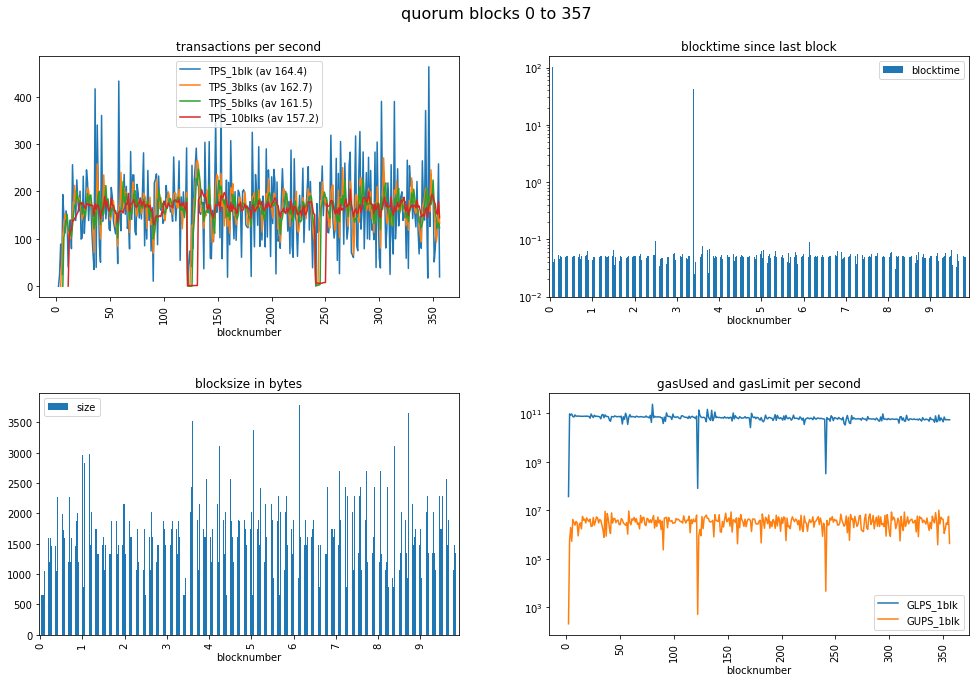

In [ ]:
# the whole range of blocks

diagrams(df, 0, 357, "quorum", gas_logy=True, bt_logy=True)

<a id='experiment1'>experiment 1 - all 4 diagrams in one</a>

# first experiment, blocks 2-121


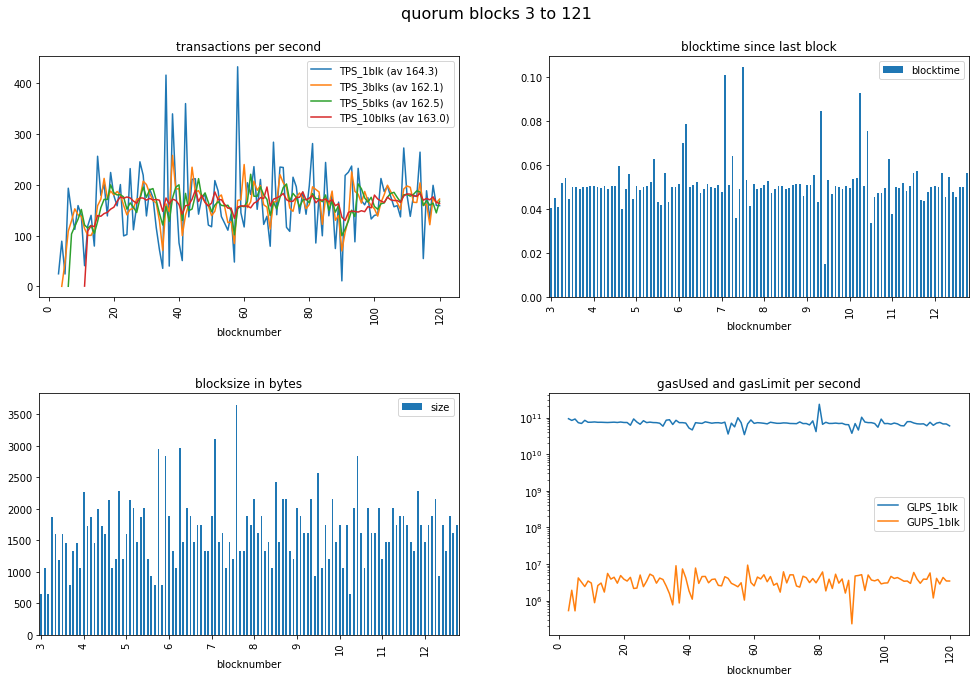

In [ ]:
# starting only at block 3 because the waiting time before experiment start created a 100s *blocktime*

diagrams(df, 3, 121, "quorum", gas_logy=True, bt_logy=False)

<a id='experiment3'>experiment 3 - all 4 diagrams in one</a>

# third experiment, blocks 241-357

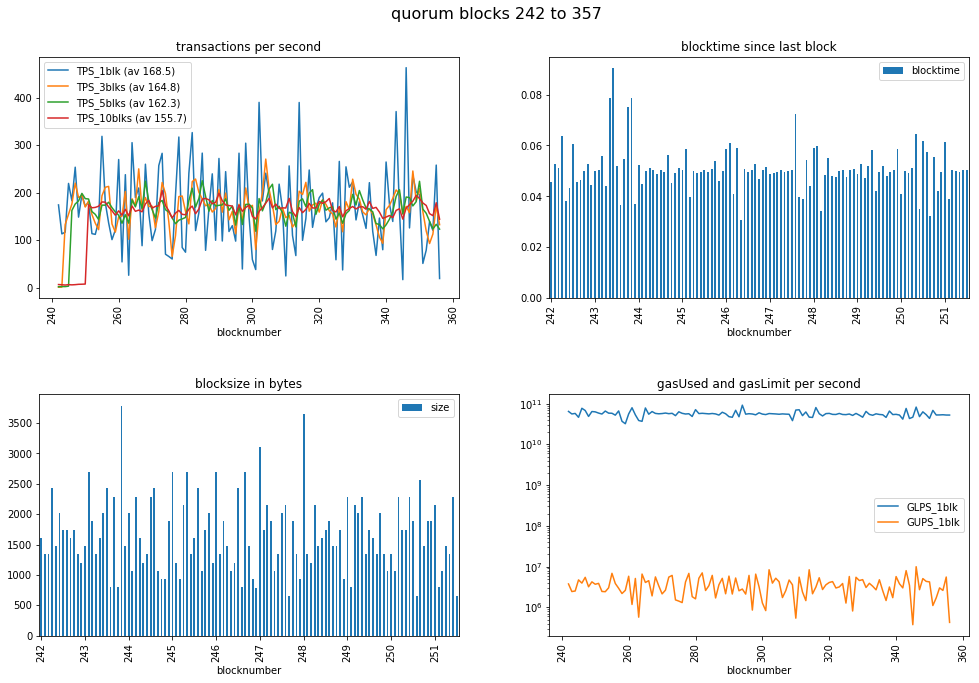

In [ ]:
# starting only at block 242 because the waiting time before experiment start created a 10s *blocktime*

diagrams(df, 242, 357, "quorum", gas_logy=True, bt_logy=False)